In [13]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from utils.model_architectures.resnet_custom import CustomResNet

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = CustomResNet(num_classes=6)

In [ ]:
model.load_state_dict(torch.load('models/basic_trash_model.pth'))
model.to(device)
model.eval()

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Load the image
image_path = 'data/dataset-resized/paper/paper559.jpg'
image = Image.open(image_path)

# Check and convert to RGB if needed
if image.mode != 'RGB':
    image = image.convert('RGB')  # Ensure the image has 3 channels (RGB)

# Apply transformations
image = transform(image)

# Add a batch dimension (1, C, H, W)
image = image.unsqueeze(0).to(device)

In [6]:
def fgsm_attack(image, epsilon):
    # Make a copy of the input image and ensure it requires gradient computation
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True

    # Forward pass
    output = model(perturbed_image)
    _, predicted_label = torch.max(output, 1)

    # Calculate the loss
    loss = nn.CrossEntropyLoss()(output, predicted_label)

    # Backward pass to calculate gradients
    model.zero_grad()
    loss.backward()

    # Collect the sign of the gradients
    data_grad = perturbed_image.grad.data.sign()

    # Create the perturbed image by adjusting each pixel by epsilon
    perturbed_image = perturbed_image + epsilon * data_grad

    # Clamp the values to be in the valid range [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


In [7]:
def iterative_fgsm_attack(image, alpha, num_iterations):
    # Make a copy of the input image and ensure it requires gradient computation
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True

    for _ in range(num_iterations):
        # Zero all existing gradients
        model.zero_grad()

        # Forward pass
        output = model(perturbed_image)
        _, predicted_label = torch.max(output, 1)

        # Calculate the loss
        loss = nn.CrossEntropyLoss()(output, predicted_label)

        # Backward pass to calculate gradients
        loss.backward()

        # Collect the sign of the gradients
        data_grad = perturbed_image.grad.data.sign()

        # Create the perturbed image by adjusting each pixel
        perturbed_image = perturbed_image + alpha * data_grad

        # Clamp the values to be in the valid range [0, 1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        # Re-attach gradient tracking to the new perturbed image
        perturbed_image = perturbed_image.clone().detach().requires_grad_(True)

    return perturbed_image

In [8]:
# Set requires_grad attribute of tensor to calculate gradients
image.requires_grad = True

# Forward pass through the model
output = model(image)

# Get the predicted label
_, initial_prediction = torch.max(output, 1)

# Calculate the loss
criterion = nn.CrossEntropyLoss()
loss = criterion(output, initial_prediction)

# Zero all existing gradients
model.zero_grad()

# Perform backward pass to calculate gradients
loss.backward()

# Collect the gradients of the input image
data_grad = image.grad.data

In [9]:
# epsilon = 0.03
# perturbed_image = fgsm_attack(image, epsilon)

In [10]:
alpha = 0.05   # Step size
num_iterations = 10  # Number of iterations
perturbed_image = iterative_fgsm_attack(image, alpha, num_iterations)

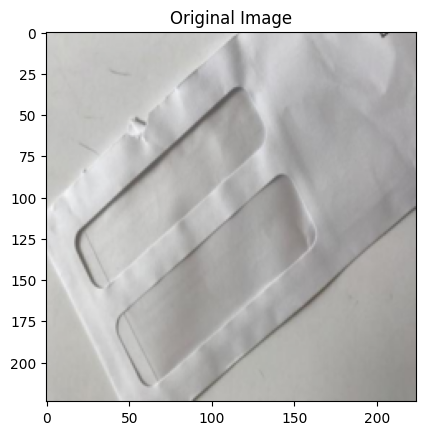

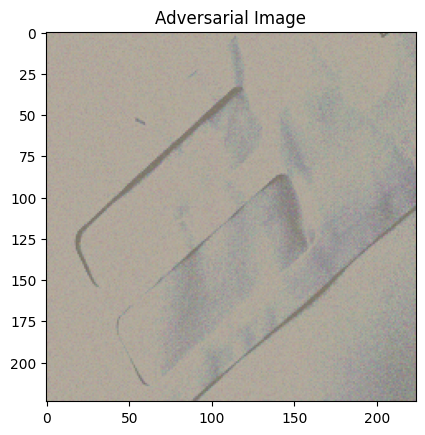

In [11]:
def imshow(image, title):
    if len(image.shape) == 4:
        image = image.squeeze(0)
    # Convert the tensor to a numpy array and denormalize
    image = image.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
    image = np.clip(image, 0, 1)  # Clip to [0, 1]
    plt.imshow(image)
    plt.title(title)
    plt.show()

# Visualize the original and adversarial images
imshow(image, "Original Image")
imshow(perturbed_image, "Adversarial Image")


In [12]:
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Re-classify the perturbed image
output = model(perturbed_image)
_, adversarial_prediction = torch.max(output, 1)

# Print the results
print(f"Original Prediction: {class_names[initial_prediction.item()]}")
print(f"Adversarial Prediction: {class_names[adversarial_prediction.item()]}")

Original Prediction: paper
Adversarial Prediction: cardboard
